<a href="https://colab.research.google.com/github/FairozAhmadSheikh/DeepLearning_Bootcamp_with_Tensor_Flow/blob/main/nlp_project/milestone_project_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lets reproduce a research paper and try to increase its accuracy**

PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts  [https://arxiv.org/abs/1710.06071]

# Dataset Used in Research Paper
[https://github.com/Franck-Dernoncourt/pubmed-rct]

In [1]:
# Clone Dataset Repository
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 14.70 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [2]:
# Check files in cloned Dataset
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Check wgat files are in Dataset
!ls pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.zip


In [4]:
# Check wgat files are in Dataset
!ls pubmed-rct/PubMed_20k_RCT

dev.txt  test.txt  train.txt


In [5]:
# start expermiments with lower dataset 20k and then we will move to 200k
data_dir="/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
# check all file names in the target directory

import os
filenames=[data_dir+filename for filename in os.listdir(data_dir) ]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

In [7]:
# Visualizing ( Become one with data)
def get_lines(filename):
    with open(filename) as f :
        return f.readlines()

In [8]:
train_lines=get_lines(data_dir+'train.txt')
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
len(train_lines)

210040

# **Preprocess Function**

**Desired Format for each abstract**

[{
'line_number':0,

'target':'BACKGROUND' or anything else,

'text':'Here goes Text',

total_lines:11 or any

}]

In [10]:
def preprocess_text_with_line_numbers(filename):
    input_lines = get_lines(filename)
    abstract_lines = ""       # Create an empty abstract
    abstract_samples = []     # Create an empty list of abstracts

    # Loop through every line
    for line in input_lines:
        if line.startswith('###'):   # checks if line is ID
            abstract_id = line
            abstract_lines = ""      # resets the abstract string if line is ID

        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()  # Split abstract into separate lines

            # Iterate through each line in a single abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                target_text_split = abstract_line.split('\t')
                line_data['target'] = target_text_split[0]
                line_data['text'] = target_text_split[1].lower()
                line_data['line_number'] = abstract_line_number
                line_data['total_lines'] = len(abstract_line_split) - 1
                abstract_samples.append(line_data)
        else:
            abstract_lines += line
    return abstract_samples


In [11]:
# get data from a file and preprocess it
%%time
train_samples=preprocess_text_with_line_numbers(data_dir+'train.txt')
val_samples=preprocess_text_with_line_numbers(data_dir+'dev.txt')
test_samples=preprocess_text_with_line_numbers(data_dir+'test.txt')

CPU times: user 333 ms, sys: 75.2 ms, total: 408 ms
Wall time: 409 ms


In [12]:
print(len(train_samples),len(val_samples),len(test_samples))

180040 30212 30135


In [13]:
# check the first abstract of the training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

**As our data is in the form of dictionaries we can change them into DataFrames** and further visualize it

In [14]:
import pandas as pd
train_df=pd.DataFrame(train_samples)
val_df=pd.DataFrame(val_samples)
test_df=pd.DataFrame(test_samples)

In [15]:
# Check now the distribution of the labels in the training data
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


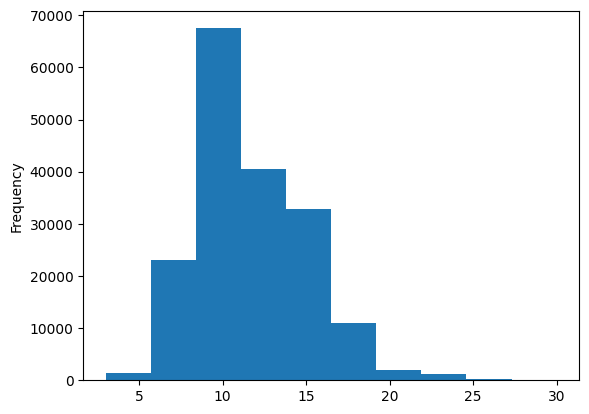

In [16]:
# cheking the length of different lines
train_df.total_lines.plot.hist();

In [17]:
# Getting the list of sentances
train_sentances=train_df['text'].to_list()
val_sentances=val_df['text'].to_list()
test_sentances=test_df['text'].to_list()

In [18]:
len(train_sentances)

180040

In [19]:
len(val_sentances)

30212

In [20]:
len(test_sentances)

30135

In [21]:
train_sentances[:10]   # View 10 lines of traiining sentenes

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

# **Make Numerical Labels (ML Models Require Numeric Labels)**

In [22]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder=OneHotEncoder(sparse_output=False)

train_label_one_hot=one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_label_one_hot=one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_label_one_hot=one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

In [23]:
train_label_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [24]:
# Label Encoded Labels     converting labels to integers
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()

train_label_encoded=label_encoder.fit_transform(train_df['target'].to_numpy())
val_label_encoded=label_encoder.fit_transform(val_df['target'].to_numpy())
test_label_encoded=label_encoder.fit_transform(test_df['target'].to_numpy())

In [25]:
train_label_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [26]:
# get class names and number of classes from Label Encoded instances
num_classes=len(label_encoder.classes_)
class_names=label_encoder.classes_
print(num_classes,class_names)

5 ['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']


# **Model_0 : Baseline Model**

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [28]:
# Create pipeline
model_0=Pipeline([
    ('tfid',TfidfVectorizer()),
    ('clf',MultinomialNB()),
])

In [29]:
# Fit the pipline to the training data
model_0.fit(X=train_sentances,y=train_label_encoded)

Pipeline(steps=[('tfid', TfidfVectorizer()), ('clf', MultinomialNB())])

In [30]:
# Evaluate Baseline model on validation dataset
model_0.score(X=val_sentances,y=val_label_encoded)

0.7218323844829869

In [31]:
# Predictions using a Baseline Model
baseline_preds=model_0.predict(val_sentances)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [32]:
# Download Helper Functions Scripts
!wget https://raw.githubusercontent.com/FairozAhmadSheikh/DeepLearning_Bootcamp_with_Tensor_Flow/refs/heads/main/helper_functions.py

--2025-11-08 03:34:56--  https://raw.githubusercontent.com/FairozAhmadSheikh/DeepLearning_Bootcamp_with_Tensor_Flow/refs/heads/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6994 (6.8K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   6.83K  --.-KB/s    in 0s      

2025-11-08 03:34:57 (97.6 MB/s) - ‘helper_functions.py’ saved [6994/6994]



In [33]:
from helper_functions import calculate_results

In [34]:
# Calculate Baseline Results
baseline_results=calculate_results(y_true=val_label_encoded,y_pred=baseline_preds)
baseline_results

{'accuracy': 0.7218323844829869,
 'precsion': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1_score': 0.6989250353450294}

***Our Baseline Has an accuracyof 72% approximately***

# **Model_1 : Conv1D with token Embeddings**

we need first to do :

    1.   Text Vectorization
    2.   Embedding



In [35]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers


In [36]:
# how long is each sentance on average ?
sent_lens=[len(sentance.split()) for sentance in train_sentances]
avg_sent_len=np.mean(sent_lens)
avg_sent_len

np.float64(26.338269273494777)

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

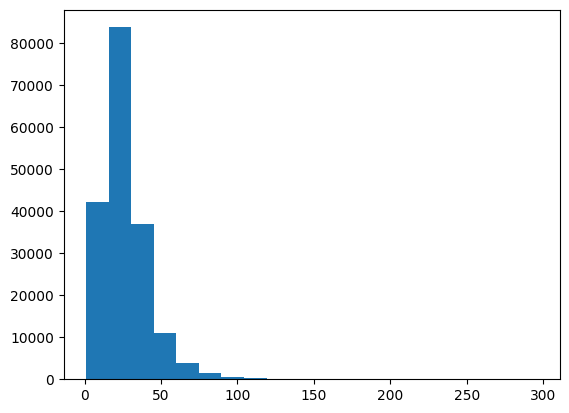

In [37]:
# what does the distribution look like
import matplotlib.pyplot as plt
plt.hist(sent_lens,bins=20)

In [38]:
# how long of sentances length cover 95% of examples?
output_seq_len=int(np.percentile(sent_lens,95))
output_seq_len

55

In [39]:
# Maximum Sequence length in the training set
max(sent_lens)

296

***Lets Create  a Text Vectorizer to map inputs(tokens) to numbersa***

In [40]:
max_tokens=68000  # as in the original research paper
from tensorflow.keras.layers import TextVectorization

text_vectorizer=TextVectorization(max_tokens=max_tokens,
                                  output_sequence_length=output_seq_len)

text_vectorizer.adapt(train_sentances)

In [41]:
# Test our text vectorizer on random sentanes
import random
target_sentence=random.choice(train_sentances)
print(f'Text :\n {target_sentence}')
print(f'\n Length of text :{len(target_sentence)}')
print(f'\n Vectorized Text :{text_vectorizer([target_sentence])}')


Text :
 prgf used in acl allograft reconstruction was associated with reduced swelling ; however , the intensity and uniformity of the graft on mri were similar in the three groups , and there was no clinical or pain improvement compared with the control group .

 Length of text :254

 Vectorized Text :[[29088    98     5  3146  4673  1314    10    81     7   191  3046   140
      2   579     3 17711     4     2  1031    18   975     9   150     5
      2   134    24     3    61    10    33    47    16    65   194    34
      7     2    35    13     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [42]:
# how many words in our training vocabulary
rct_20k_text_vocab=text_vectorizer.get_vocabulary()
print(f'Number of words in vocab :{len(rct_20k_text_vocab)}')
print(f'Most common words in the vocab :{rct_20k_text_vocab[:5]}')
print(f'Least common words in the vocab :{rct_20k_text_vocab[-5:]}')

Number of words in vocab :64841
Most common words in the vocab :['', '[UNK]', np.str_('the'), np.str_('and'), np.str_('of')]
Least common words in the vocab :[np.str_('aainduced'), np.str_('aaigroup'), np.str_('aachener'), np.str_('aachen'), np.str_('aaacp')]


In [43]:
# get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [44]:
# Create custom text embedding
token_embed=tf.keras.layers.Embedding(
    input_dim=len(rct_20k_text_vocab),
    output_dim=128,
    mask_zero=True,name='token_embedding'
)

In [45]:
# show example embedding
print(f'Sentence before vectorization :\n{target_sentence}\n')
vectorized_sentence=text_vectorizer([target_sentence])
print(f'Sentence after vectorization ( Before Embedding) : \n{vectorized_sentence}')
embedded_sentence=token_embed(vectorized_sentence)
print(f'sentence after embedding : \ n {embedded_sentence}\n ')
print(f'Embedded Sentence Shape :{embedded_sentence.shape}')

Sentence before vectorization :
prgf used in acl allograft reconstruction was associated with reduced swelling ; however , the intensity and uniformity of the graft on mri were similar in the three groups , and there was no clinical or pain improvement compared with the control group .

Sentence after vectorization ( Before Embedding) : 
[[29088    98     5  3146  4673  1314    10    81     7   191  3046   140
      2   579     3 17711     4     2  1031    18   975     9   150     5
      2   134    24     3    61    10    33    47    16    65   194    34
      7     2    35    13     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


<>:6: SyntaxWarning: invalid escape sequence '\ '
<>:6: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-2745396381.py:6: SyntaxWarning: invalid escape sequence '\ '
  print(f'sentence after embedding : \ n {embedded_sentence}\n ')


sentence after embedding : \ n [[[ 0.04175362 -0.02055138 -0.03720571 ...  0.04428336 -0.02412269
   -0.01120115]
  [ 0.03442303 -0.04633958  0.00298578 ... -0.04463181  0.04732886
    0.04917008]
  [ 0.01360433 -0.04857129 -0.04679134 ...  0.00287311 -0.04079788
    0.02201129]
  ...
  [-0.02556679  0.00356076 -0.02937942 ...  0.00161661 -0.01170881
    0.01706799]
  [-0.02556679  0.00356076 -0.02937942 ...  0.00161661 -0.01170881
    0.01706799]
  [-0.02556679  0.00356076 -0.02937942 ...  0.00161661 -0.01170881
    0.01706799]]]
 
Embedded Sentence Shape :(1, 55, 128)


# **Making Sure our Datasets load Faster using Tf.data API**

In [46]:
# Turn our data into tensorflow datasets
train_dataset=tf.data.Dataset.from_tensor_slices((train_sentances,train_label_one_hot))
test_dataset=tf.data.Dataset.from_tensor_slices((test_sentances,test_label_one_hot))
valid_dataset=tf.data.Dataset.from_tensor_slices((val_sentances,val_label_one_hot))

In [47]:
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [48]:
#Take the tensor slice datasets and turn them into prefetch  datasets
train_dataset=train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset=valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# **MODEL 1 : Conv1D with token embedding**

In [49]:
inputs=tf.keras.layers.Input(shape=(1,),dtype=tf.string)
text_vectors=text_vectorizer(inputs)
token_embeddings=token_embed(text_vectors)
x=layers.Conv1D(64,kernel_size=5,padding='same',activation='relu')(token_embeddings)
x=layers.GlobalMaxPooling1D()(x)
outputs=layers.Dense(num_classes,activation='softmax')(x)
model_1=tf.keras.Model(inputs,outputs)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [50]:
model_1.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])



In [51]:
model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 55)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_embedding (Embedding)     │ (None, 55, 128)        │     8,299,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 55, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,340,997 (31.82 MB)

 Trainable params: 8,340,997 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# Train the Model
history_model_1=model_1.fit(train_dataset,steps_per_epoch=int(0.1*len(train_dataset)),epochs=3,
                            validation_data=valid_dataset,
                            validation_steps=int(0.1*len(valid_dataset)))


Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.5636 - loss: 1.1074 - val_accuracy: 0.7816 - val_loss: 0.5921
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7858 - loss: 0.5916 - val_accuracy: 0.7952 - val_loss: 0.5447
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7968 - loss: 0.5425 - val_accuracy: 0.8072 - val_loss: 0.5239


In [53]:
# Evaluate on validataion dataset
model_1.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8058 - loss: 0.5204


[0.5236479043960571, 0.8049450516700745]

In [54]:
model_1.evaluate(test_dataset)

942/942 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7988 - loss: 0.5396


[0.5381782650947571, 0.8017919659614563]

In [55]:
# Make Predictions
model_1_pred_probs=model_1.predict(valid_dataset)
model_1_pred_probs,model_1_pred_probs.shape

945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


(array([[5.94457448e-01, 7.71641433e-02, 1.47451425e-03, 3.25932443e-01,
         9.71513917e-04],
        [2.23929510e-01, 6.63531005e-01, 6.19817409e-04, 1.08231165e-01,
         3.68846674e-03],
        [1.34565338e-01, 4.54415055e-03, 5.30053489e-03, 8.55370402e-01,
         2.19651803e-04],
        ...,
        [3.16882681e-04, 3.61661450e-03, 9.58318915e-03, 2.09629710e-04,
         9.86273706e-01],
        [1.17554665e-02, 6.64732695e-01, 4.39141952e-02, 1.09350793e-02,
         2.68662602e-01],
        [1.05331959e-02, 9.83439922e-01, 8.79216124e-04, 4.04882059e-03,
         1.09888497e-03]], dtype=float32),
 (30212, 5))

In [56]:
# Convert Pred probs to classes
model_1_preds=tf.argmax(model_1_pred_probs,axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 1, 1])>

In [57]:
# Calculate Results
model_1_results=calculate_results(y_true=val_label_encoded,y_pred=model_1_preds)
model_1_results

{'accuracy': 0.804945054945055,
 'precsion': 0.80391225985645,
 'recall': 0.804945054945055,
 'f1_score': 0.8032938692089793}

# Model 1 beats Baseline Model

# ***Model 2  Feature extraction with pretrained token Embedding***

In [58]:
import tensorflow_hub as hub
url="https://tfhub.dev/google/universal-sentence-encoder/4"
tf_hub_embedding_layer=hub.KerasLayer(url,trainable=False,name='universal_sentence_encoder')

In [59]:
# Test out

random_train_sentence=random.choice(train_sentances)
print(f'Random Sentence :\n {random_train_sentence}')

Random Sentence :
 the authors performed a randomized controlled trial of an @-week course of ea compared with a waitlist control ( wlc ) group and a sham acupuncture ( sa ) group in postmenopausal women with breast cancer who self-reported joint pain attributable to ais .


In [60]:
use_embedded_sentences=tf_hub_embedding_layer([random_train_sentence])
print(f'Sentence after Embedding :\n {use_embedded_sentences[0][:30]}')
print(f'Length of sentence Embedding : {len(use_embedded_sentences[0])}')

Sentence after Embedding :
 [-0.04851696 -0.03972884  0.02013547 -0.06903789 -0.0313193   0.0002174
  0.04929501 -0.06687361 -0.02243404 -0.04132577  0.07847805 -0.07107615
  0.07205361 -0.01284897  0.04478915  0.01721354 -0.07538258  0.03674455
  0.02601006 -0.01846734 -0.01468254  0.0792497  -0.03188691  0.00075808
  0.06316696  0.04267215 -0.05463915  0.03834249 -0.02477331 -0.0253007 ]
Length of sentence Embedding : 512


In [61]:
# Building and Fit NLP Feature Extractor
# Custom wrapper layer for tf_hub_embedding_layer to handle KerasTensor binding issue
class UniversalSentenceEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(UniversalSentenceEncoderLayer, self).__init__(**kwargs)
        # The pre-loaded KerasLayer from TF-Hub
        self.pretrained_encoder = tf_hub_embedding_layer

    def call(self, inputs):
        # Pass the inputs through the pre-trained encoder
        return self.pretrained_encoder(inputs)

inputs=layers.Input(shape=[],dtype=tf.string)
# Use the custom wrapper layer to properly integrate the TF-Hub embedding
pretrained_embedding=UniversalSentenceEncoderLayer()(inputs)
x=layers.Dense(128,activation='relu')(pretrained_embedding)
outputs=layers.Dense(num_classes,activation='softmax')(x)
model_2=tf.keras.Model(inputs,outputs,name='model_2_USE_feature_extractor')

In [66]:
model_2.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'],
                jit_compile=False)

In [63]:
model_2.summary()

Model: "model_2_USE_feature_extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ universal_sentence_encoder_lay… │ (None, 512)            │             0 │
│ (UniversalSentenceEncoderLayer) │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,309 (259.02 KB)

 Trainable params: 66,309 (259.02 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
# Model_2 train
history_model_2=model_2.fit(train_dataset,
                            epochs=3,
                            steps_per_epoch=int(0.1*len(train_dataset)),
                            validation_data=valid_dataset,
                            validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.5786 - loss: 1.0952 - val_accuracy: 0.6912 - val_loss: 0.7967
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.7037 - loss: 0.7716 - val_accuracy: 0.7021 - val_loss: 0.7561
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7127 - loss: 0.7554 - val_accuracy: 0.7128 - val_loss: 0.7398


In [68]:
# Evaluate on whole dataset
model_2.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.7131 - loss: 0.7407


[0.7421234846115112, 0.7135244011878967]

In [69]:
# Make predictions
model_2_pred_probs=model_2.predict(valid_dataset)
model_2_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step


array([[4.4142115e-01, 3.6259934e-01, 2.5636372e-03, 1.8491767e-01,
        8.4982272e-03],
       [3.7531966e-01, 4.6159041e-01, 4.5131580e-03, 1.5598169e-01,
        2.5951539e-03],
       [2.3904981e-01, 1.5834169e-01, 2.0503938e-02, 5.4278111e-01,
        3.9323423e-02],
       ...,
       [1.9732860e-03, 5.8827759e-03, 5.0795157e-02, 8.6551113e-04,
        9.4048333e-01],
       [4.1284189e-03, 4.5637857e-02, 2.0964831e-01, 1.4022568e-03,
        7.3918313e-01],
       [1.6351645e-01, 2.3792082e-01, 5.2903301e-01, 9.0526519e-03,
        6.0477048e-02]], dtype=float32)

In [70]:
model_2_preds=tf.argmax(model_2_pred_probs,axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [73]:
# Calcualate Result for model_2
model_2_results=calculate_results(y_true=val_label_encoded,
                                  y_pred=model_2_preds)
model_2_results

{'accuracy': 0.7135244273798491,
 'precsion': 0.7137818359361368,
 'recall': 0.7135244273798491,
 'f1_score': 0.7105866497662505}

*Model 2 does not beat Baseline or Model 1's accuracy*

# **Lets Now Build Model3 :**

1.  Conv1D with character Encoding

In [76]:
# Make a function that splits the sentences to the characters
def split_chars(text):
    return " ".join(list(text))

In [77]:
# Example use-case
split_chars(random_train_sentence)

't h e   a u t h o r s   p e r f o r m e d   a   r a n d o m i z e d   c o n t r o l l e d   t r i a l   o f   a n   @ - w e e k   c o u r s e   o f   e a   c o m p a r e d   w i t h   a   w a i t l i s t   c o n t r o l   (   w l c   )   g r o u p   a n d   a   s h a m   a c u p u n c t u r e   (   s a   )   g r o u p   i n   p o s t m e n o p a u s a l   w o m e n   w i t h   b r e a s t   c a n c e r   w h o   s e l f - r e p o r t e d   j o i n t   p a i n   a t t r i b u t a b l e   t o   a i s   .'

In [79]:
# Split sequence level data into into character level data splits
train_chars=[split_chars(sentence) for sentence in train_sentances]
val_chars=[split_chars(sentence) for sentence in val_sentances]
test_chars=[split_chars(sentence) for sentence in test_sentances]

In [80]:
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [87]:
# find average length of chars
char_lens=[len(sentence) for sentence in train_sentances]
mean_char_lens=np.mean(char_lens)
mean_char_lens

np.float64(149.3662574983337)

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

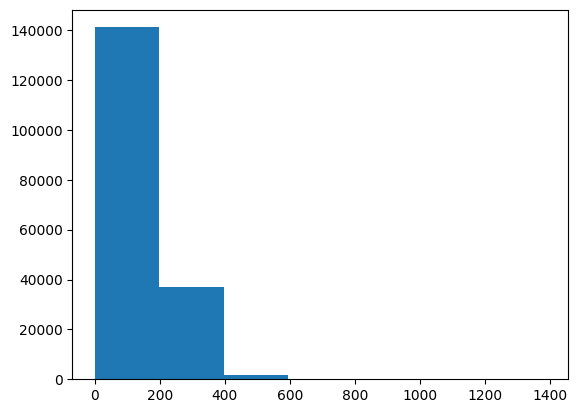

In [88]:
# Finding the distribution character level
import matplotlib.pyplot as plt
plt.hist(char_lens,bins=7)

In [89]:
# finding what character lenght covers 95% of sequences
output_seq_char_len=int(np.percentile(char_lens,95))
output_seq_char_len

290

In [91]:
# Getting all keyboard Characters
import string
alphabet=string.ascii_lowercase+string.digits+string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [92]:
len(alphabet)

68